# Task1 :Data preparation 

This section is dedicated to preparing the data in the TFRecord format

In [1]:
import os
import tensorflow as tf
import io
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import glob



2024-03-19 14:19:25.096481: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-19 14:19:25.096641: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-19 14:19:25.246461: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**Step 1:Helper Functions for TFRecord Features**


These functions convert data into a format suitable for TensorFlow's efficient data handling and storage.

In [106]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()  # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

**Step 3: Serializing Data into TFRecord Format**

This step involves the serialization of image data along with its metadata into a format that is compatible with TensorFlow's TFRecord.

In [107]:
def serialize_example(image_path, label, xmin, ymin, xmax, ymax):
    with tf.io.gfile.GFile(image_path, 'rb') as fid:
        encoded_jpg = fid.read()
    image = Image.open(io.BytesIO(encoded_jpg))
    width, height = image.size

    feature = {
        "image/width": _int64_feature(width),
        "image/height": _int64_feature(height),
        'image/filename': _bytes_feature(tf.compat.as_bytes(os.path.basename(image_path))),
        'image/source_id': _bytes_feature(tf.compat.as_bytes(os.path.basename(image_path))),
        'image/encodedrawdata': _bytes_feature(encoded_jpg),
        'image/format': _bytes_feature(b'jpeg'),
        'image/object/bbox/xmin': _float_feature(xmin),
        'image/object/bbox/xmax': _float_feature(xmax),
        'image/object/bbox/ymin': _float_feature(ymin),
        'image/object/bbox/ymax': _float_feature(ymax),
        'image/object/class/text': _bytes_feature(b'placeholder'),  # Replace 'placeholder' with actual class name if available
        'image/object/class/label': _int64_feature(label),
        'image/object/class/single': _int64_feature(label),  # Assuming label is correct for 'single'
        'image/object/difficult': _int64_feature(0),
        'image/object/truncated': _int64_feature(0),
        'image/object/view': _bytes_feature(b'Frontal'),
    }

    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

In [108]:
# Define a mapping from directory names to unique integer labels
label_map = {
    'crazing': 0,
    'inclusion': 1,
    'patches': 2,
    'pitted_surface': 3,
    'rolled-in_scale': 4,
    'scratches': 5
}

In [109]:
def extract_bbox_from_xml(xml_file_path):
    try:
        tree = ET.parse(xml_file_path)
        root = tree.getroot()
        bndbox = root.find('.//bndbox')
        if bndbox is not None:
            bbox = {
                'xmin': float(bndbox.find('xmin').text),
                'ymin': float(bndbox.find('ymin').text),
                'xmax': float(bndbox.find('xmax').text),
                'ymax': float(bndbox.find('ymax').text)
            }
        else:
            # Provide default values if bbox extraction fails
            bbox = {'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}
        return bbox
    except Exception as e:
        print(f"Error extracting bbox from {xml_file_path}: {e}")
        # Return a dictionary with default values in case of error
        return {'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}



**Step 4: Write TFRecord Files**

In [114]:
def write_tfrecords_for_dataset(data_dir, output_dir, annotations_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    total_images = 0
    for category in label_map.keys():
        category_path = os.path.join(data_dir, category)
        images = [img for img in os.listdir(category_path) if img.lower().endswith(('png', 'jpg', 'jpeg'))]
        total_images += len(images)
        
        for image_name in images:
            image_path = os.path.join(category_path, image_name)
            xml_file_path = os.path.join(annotations_dir, image_name.replace('.jpg', '.xml').replace('.jpeg', '.xml').replace('.png', '.xml'))
            
            bbox = extract_bbox_from_xml(xml_file_path)
            if bbox is None:
                continue
            
            tfrecord_filename = os.path.join(output_dir, f"{category}_{image_name}.tfrecord")
            label = label_map[category]
            

            serialized_example = serialize_example(image_path, label, bbox['xmin'], bbox['ymin'], bbox['xmax'], bbox['ymax'])
            
            with tf.io.TFRecordWriter(tfrecord_filename) as writer:
                writer.write(serialized_example)
    
    print(f"Total {total_images} images found and processed in {data_dir}")
    print(f"TFRecord files written to {output_dir}")


**Step 5: Setting Up Dataset Directories for Training and Testing**

In [115]:
train_data_dir = '/kaggle/input/neu-surface-defect-database/NEU-DET/train/images'
train_annotations_dir = '/kaggle/input/neu-surface-defect-database/NEU-DET/train/annotations'
test_data_dir = '/kaggle/input/neu-surface-defect-database/NEU-DET/validation/images'
test_annotations_dir='/kaggle/input/neu-surface-defect-database/NEU-DET/validation/annotations'

****Output directories for TFRecords****

In [116]:

train_output_dir = '/kaggle/working/train_tfrecords'
test_output_dir = '/kaggle/working/test_tfrecords'


**Step 6: Generate TFRecords**

In [117]:
write_tfrecords_for_dataset(train_data_dir, train_output_dir,train_annotations_dir)
write_tfrecords_for_dataset(test_data_dir, test_output_dir,test_annotations_dir)

Error extracting bbox from /kaggle/input/neu-surface-defect-database/NEU-DET/train/annotations/crazing_240.xml: [Errno 2] No such file or directory: '/kaggle/input/neu-surface-defect-database/NEU-DET/train/annotations/crazing_240.xml'
Total 1440 images found and processed in /kaggle/input/neu-surface-defect-database/NEU-DET/train/images
TFRecord files written to /kaggle/working/train_tfrecords
Total 360 images found and processed in /kaggle/input/neu-surface-defect-database/NEU-DET/validation/images
TFRecord files written to /kaggle/working/test_tfrecords


In [118]:
!ls /kaggle/working/test_tfrecords | head


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


crazing_crazing_241.jpg.tfrecord
crazing_crazing_242.jpg.tfrecord
crazing_crazing_243.jpg.tfrecord
crazing_crazing_244.jpg.tfrecord
crazing_crazing_245.jpg.tfrecord
crazing_crazing_246.jpg.tfrecord
crazing_crazing_247.jpg.tfrecord
crazing_crazing_248.jpg.tfrecord
crazing_crazing_249.jpg.tfrecord
crazing_crazing_250.jpg.tfrecord


**Parsing and Decoding single TFRecosrd example into an image**


In [126]:

import matplotlib.pyplot as plt
import tensorflow as tf

def parse_tfrecord(tfrecord):
    """
    Decodes a single TFRecord example into an image and its corresponding bounding boxes.

    Parameters:
    tfrecord: The serialized TFRecord example to parse.

    Returns:
    A tuple containing:
    - A tensor representing the decoded JPEG image.
    - A dictionary with the bounding box coordinates.
    """
    feature_description = {
        "image/encodedrawdata": tf.io.FixedLenFeature([], tf.string),
        "image/object/bbox/xmin": tf.io.FixedLenFeature([], tf.float32),
        "image/object/bbox/xmax": tf.io.FixedLenFeature([], tf.float32),
        "image/object/bbox/ymin": tf.io.FixedLenFeature([], tf.float32),
        "image/object/bbox/ymax": tf.io.FixedLenFeature([], tf.float32),
    }
    example = tf.io.parse_single_example(tfrecord, feature_description)
    image = tf.image.decode_jpeg(example['image/encodedrawdata'], channels=3)
    bbox = {
        'xmin': example['image/object/bbox/xmin'],
        'xmax': example['image/object/bbox/xmax'],
        'ymin': example['image/object/bbox/ymin'],
        'ymax': example['image/object/bbox/ymax']
    }
    return image, bbox

In [124]:
def draw_bbox(image, bbox):
    """
    Draws bounding boxes on the image.

    Parameters:
    image: The image tensor.
    bbox: The dictionary with bounding box coordinates.

    Returns:
    An image with bounding boxes drawn.
    """
    plt.figure(figsize=(6,6))
    plt.imshow(image)
    plt.gca().add_patch(plt.Rectangle((bbox['xmin'], bbox['ymin']), bbox['xmax'] - bbox['xmin'], bbox['ymax'] - bbox['ymin'], 
                                      linewidth=1, edgecolor='r', facecolor='none'))
    plt.axis('off')
    plt.show()

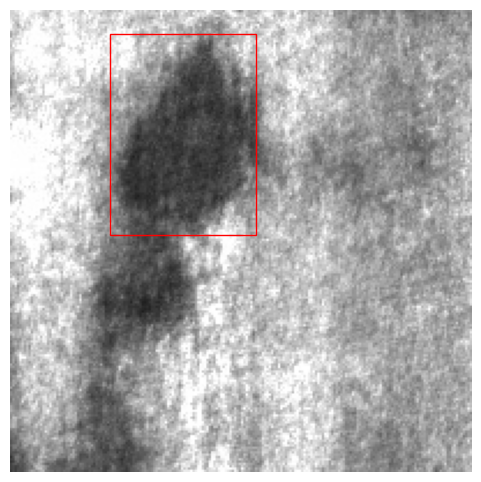

In [125]:
# Reading and displaying an image with its bounding box from TFRecord
raw_dataset = tf.data.TFRecordDataset(['/kaggle/working/train_tfrecords/patches_patches_1.jpg.tfrecord'])
for raw_record in raw_dataset.take(1):
    image, bbox = parse_tfrecord(raw_record)
    draw_bbox(image.numpy(), bbox)

**Label Extraction and Verification from TFRecord Files**

In [122]:
def read_and_print_label_from_tfrecord(tfrecord_file):
    """
Reads and prints the label from a TFRecord file.

Processes and prints labels from a TFRecord file, which is expected to include 'image/encodedrawdata' and 'image/object/class/label'.
It converts the file into a dataset, parses it using a defined structure, and prints each extracted label.
Useful for content verification or debugging.

Parameters:

tfrecord_file: The path to the TFRecord file to be read.
  """
    raw_dataset = tf.data.TFRecordDataset([tfrecord_file])

    # Define feature structure
    feature_description = {
        'image/encodedrawdata': tf.io.FixedLenFeature([], tf.string),
        'image/object/class/label': tf.io.FixedLenFeature([], tf.int64),
    }

    def _parse_function(example_proto):
        # Parse the input `tf.train.Example` proto using the feature description.
        return tf.io.parse_single_example(example_proto, feature_description)

    for parsed_record in raw_dataset.map(_parse_function):
        label = parsed_record['image/object/class/label'].numpy()
        print(f"Label: {label}")

# Example usage
tfrecord_to_check = '/kaggle/working/train_tfrecords/scratches_scratches_67.jpg.tfrecord'#expected result : 5 
read_and_print_label_from_tfrecord(tfrecord_to_check)

Label: 5


**Gathering TFRecord Files for Training and Testing Sets**

Used glob.glob to expand the wildcard pattern to a list of TFRecord files

In [123]:
train_tfrecord_files = glob.glob('/kaggle/working/train_tfrecords/*.tfrecord')
test_tfrecord_files = glob.glob('/kaggle/working/test_tfrecords/*.tfrecord')
# Verify that files are found
print(f"Found {len(train_tfrecord_files)} training TFRecord files")
print(f"Found {len(test_tfrecord_files)} testing TFRecord files")


Found 1440 training TFRecord files
Found 360 testing TFRecord files


Download output data for later use 

In [129]:
#!zip -r dataset.zip train_tfrecords test_tfrecords
